# Clean

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from adjustText import adjust_text 
import pickle 
import math
import scanpy as sc
import pandas as pd

In [ ]:
# # linear 2k genes
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear_hvg/linear_baseline_hvg.h5ad')
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-26_17-20-19/1/evaluation/eval.pkl"

# linear 32k genes
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear/linear_baseline.h5ad')
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-28_13-44-13/2/evaluation/eval.pkl"

# # STATE latent 32k genes
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear/linear_baseline.h5ad')
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-11-07_09-32-27_boli_linear_baseline/evaluation/eval.pkl"
# model_name = "LatentAdditive"

# STATE latent 2k HVG
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear_hvg/linear_baseline_hvg.h5ad')
pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-11-07_09-53-57_boli_linear_baseline/evaluation/eval.pkl"
model_name = "LatentAdditive"

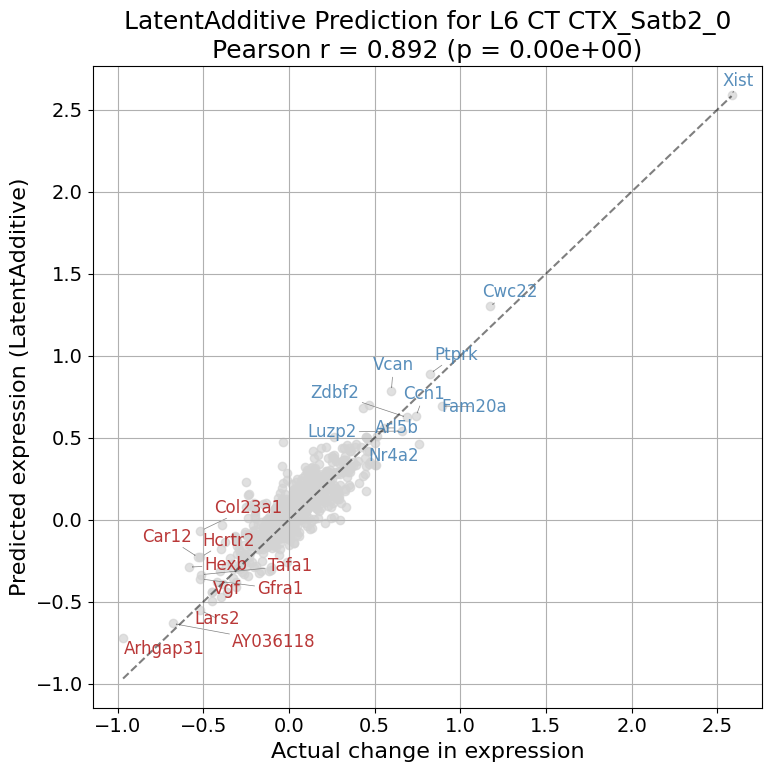

No DEGs found for L6 CT CTX_Satb2_0, skipping DEG plot


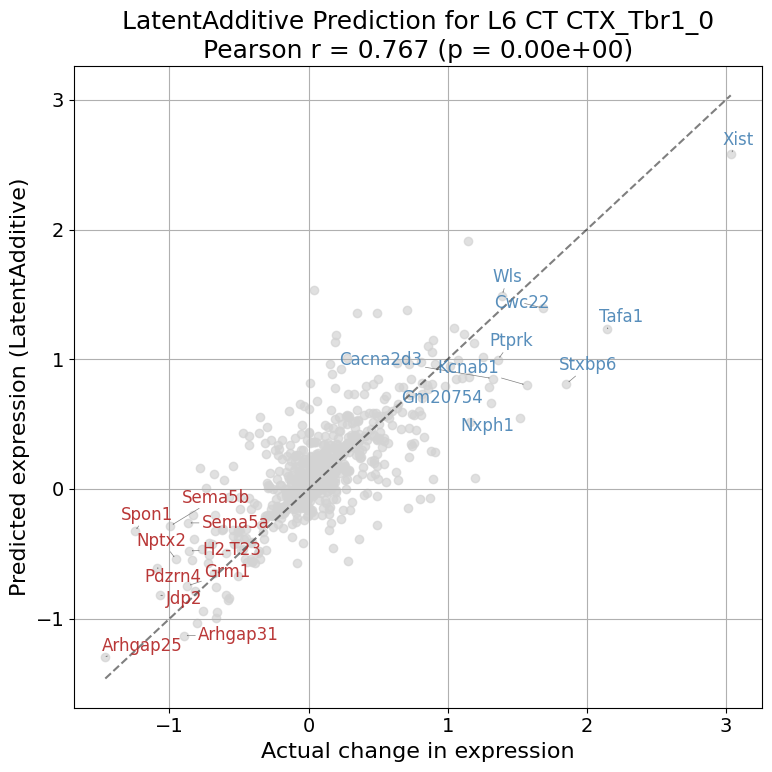

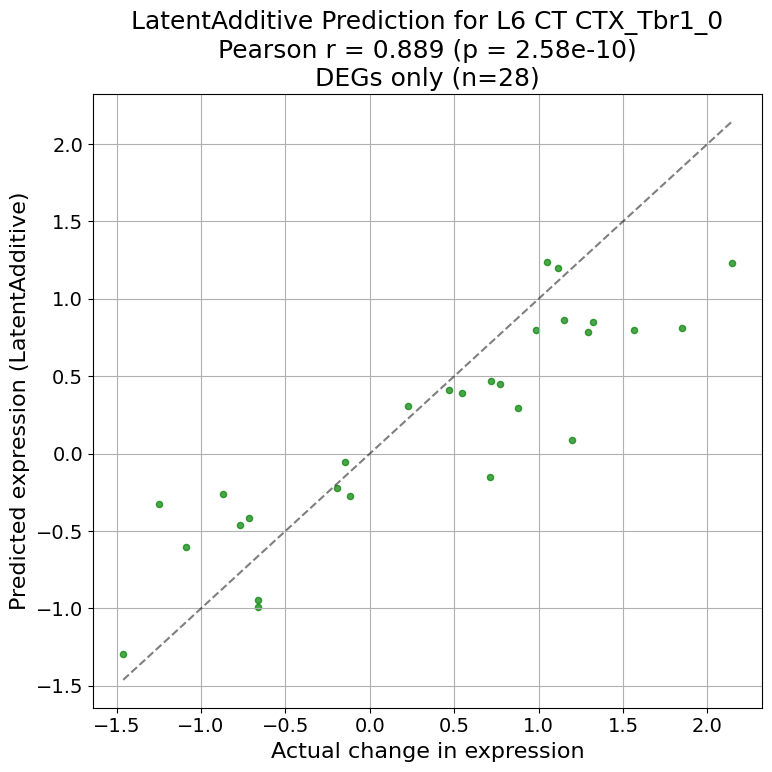

Completed plots for L6 CT CTX_Tbr1_0: 2000 total genes, 28 DEGs


In [28]:

# ============ STYLE CONFIGURATION ============
FIGSIZE = 10  # inches
FONTSIZE_TITLE = 18
FONTSIZE_LABEL = 16
FONTSIZE_ANNOTATION = 10
MARKERSIZE_ALL = 30
MARKERSIZE_DEG = 25
DPI = 300

# Set global font sizes
plt.rcParams.update({
    'font.size': FONTSIZE_LABEL,
    'axes.labelsize': FONTSIZE_LABEL,
    'axes.titlesize': FONTSIZE_TITLE,
    'xtick.labelsize': FONTSIZE_LABEL - 2,
    'ytick.labelsize': FONTSIZE_LABEL - 2,
})
# ============ STYLE CONFIGURATION ============


with open(pkl_res, "rb") as f:
    eval_data = pickle.load(f)
df_pred = eval_data.aggr["logfc"][model_name].to_df()
df_ref = eval_data.aggr["logfc"]["ref"].to_df()
genes = boli.var["gene_name"].values

cell_perts = df_pred.index.tolist()

# Function to load DEG genes for a specific cell type and perturbation
def load_deg_genes(cell_pert):
    """
    Load DEG genes for a specific cell type and perturbation.
    Modify the path pattern to match your file naming convention.
    """
    # Parse cell_pert to extract cell type and perturbation
    # Example: "L6 CT CTX_Tbr1_0" -> cell_type="L6_CT_CTX", perturbation="Tbr1"
    parts = cell_pert.split("_")
    cell_type = "_".join(parts[:-2])  # e.g., "L6 CT CTX"
    perturbation = parts[-2]  # e.g., "Tbr1"
    
    # Construct the DEG file path
    # Adjust this pattern to match your actual file naming convention
    deg_file = f"/gpfs/home/asun/jin_lab/perturbench/raw_data/top100_ctx_{perturbation.lower()}_{cell_type.replace(' ', '_')}.csv"
    
    try:
        deg_df = pd.read_csv(deg_file)
        return set(deg_df["names"].tolist())
    except FileNotFoundError:
        print(f"Warning: DEG file not found for {cell_pert}: {deg_file}")
        return set()

# Plot for each cell_pert individually
for cell_pert in cell_perts:
    # Plot 1: All genes
    fig, ax = plt.subplots(figsize=(8, 8))
    
    x_vals = df_ref.loc[cell_pert].values
    y_vals = df_pred.loc[cell_pert].values
    
    pearson_r, p_value = pearsonr(x_vals, y_vals)

    top10_idx = np.argsort(x_vals)[-10:]
    bottom10_idx = np.argsort(x_vals)[:10]
    top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

    ax.scatter(x_vals, y_vals, alpha=0.7, color="lightgray")
    ax.plot([x_vals.min(), x_vals.max()], [x_vals.min(), x_vals.max()], 'k--', alpha=0.5)
    ax.set_xlabel("Actual change in expression")
    ax.set_ylabel(f"Predicted expression ({model_name})")
    ax.set_title(f"{model_name} Prediction for {cell_pert}\nPearson r = {pearson_r:.3f} (p = {p_value:.2e})")
    ax.grid(True)

    texts = []
    for idx in top_and_bottom_idx:
        color = "steelblue" if idx in top10_idx else "firebrick"
        texts.append(
            ax.text(
                x_vals[idx], y_vals[idx], genes[idx],
                fontsize=12,
                color=color,
                alpha=0.9,
                ha='right' if idx in top10_idx else 'left',
                va='bottom'
            )
        )
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)
    
    plt.tight_layout()
    #plt.savefig(f"{cell_pert}_all_genes.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Plot 2: DEGs only for this specific cell_pert
    deg_genes = load_deg_genes(cell_pert)
    
    if len(deg_genes) > 0:
        # Create mask for DEG genes
        deg_mask = np.array([gene in deg_genes for gene in genes])
        deg_indices = np.where(deg_mask)[0]
        
        # Subset dataframes to only DEG genes
        df_pred_deg = df_pred.iloc[:, deg_indices]
        df_ref_deg = df_ref.iloc[:, deg_indices]
        genes_deg = genes[deg_mask]
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        x_vals_deg = df_ref_deg.loc[cell_pert].values
        y_vals_deg = df_pred_deg.loc[cell_pert].values

        pearson_r, p_value = pearsonr(x_vals_deg, y_vals_deg)

        top10_idx = np.argsort(x_vals_deg)[-10:]
        bottom10_idx = np.argsort(x_vals_deg)[:10]
        top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

        # Plot all DEG genes in green
        ax.scatter(x_vals_deg, y_vals_deg, alpha=0.7, color="green", s=20)

        ax.plot([x_vals_deg.min(), x_vals_deg.max()], [x_vals_deg.min(), x_vals_deg.max()], 'k--', alpha=0.5)
        ax.set_xlabel("Actual change in expression")
        ax.set_ylabel(f"Predicted expression ({model_name})")
        ax.set_title(f"{model_name} Prediction for {cell_pert}\nPearson r = {pearson_r:.3f} (p = {p_value:.2e})\nDEGs only (n={len(genes_deg)})")
        ax.grid(True)
        
        # texts = []
        # for idx in top_and_bottom_idx:
        #     color = "steelblue" if idx in top10_idx else "firebrick"
        #     texts.append(
        #         ax.text(
        #             x_vals_deg[idx], y_vals_deg[idx], genes_deg[idx],
        #             fontsize=12,
        #             color=color,
        #             alpha=0.9,
        #             ha='right' if idx in top10_idx else 'left',
        #             va='bottom'
        #         )
        #     )
        # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)
        
        plt.tight_layout()
        #plt.savefig(f"{cell_pert}_DEGs_only.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print(f"Completed plots for {cell_pert}: {len(genes)} total genes, {len(genes_deg)} DEGs")
    else:
        print(f"No DEGs found for {cell_pert}, skipping DEG plot")

# Scratch

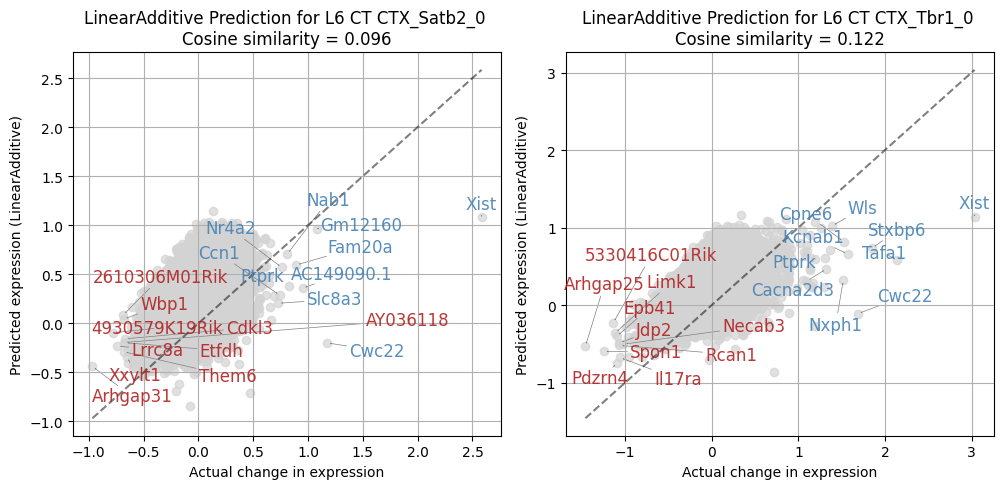

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from adjustText import adjust_text 
import pickle 
import math
import scanpy as sc

boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/raw_data/boli_ctx_scprocess_no+ctrl.h5ad')
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear/linear_baseline.h5ad')


pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-09-26_11-01-16_boli_linear_baseline/evaluation/eval.pkl"
pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-07_11-33-35/3/evaluation/eval.pkl"
pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-26_17-20-19/1/evaluation/eval.pkl"


pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-28_13-44-13/2/evaluation/eval.pkl"

with open(pkl_res, "rb") as f:
    eval_data = pickle.load(f)
model_name = "LinearAdditive"
df_pred = eval_data.aggr["logfc"][model_name].to_df()
df_ref = eval_data.aggr["logfc"]["ref"].to_df()
genes = boli.var["gene_name"].values


cell_perts = df_pred.index.tolist()
num_plots = len(cell_perts)
cols = int(math.ceil(math.sqrt(num_plots))) + 2
rows = int(math.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.flatten()
for i, cell_pert in enumerate(cell_perts):
    ax = axes[i]
    x_vals = df_ref.loc[cell_pert].values
    y_vals = df_pred.loc[cell_pert].values
    cos_sim = cosine_similarity(x_vals.reshape(1, -1), y_vals.reshape(1, -1))[0, 0]

    top10_idx = np.argsort(x_vals)[-10:]
    bottom10_idx = np.argsort(x_vals)[:10]
    top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

    colors = ["steelblue" if idx in top10_idx else "firebrick" for idx in range(len(y_vals))]

    ax.scatter(x_vals, y_vals, alpha=0.7, color="lightgray")
    ax.plot([x_vals.min(), x_vals.max()], [x_vals.min(), x_vals.max()], 'k--', alpha=0.5)
    ax.set_xlabel("Actual change in expression")
    ax.set_ylabel(f"Predicted expression ({model_name})")
    ax.set_title(f"{model_name} Prediction for {cell_pert} \nCosine similarity = {cos_sim:.3f}")
    ax.grid(True)

    texts = []
    for idx in top_and_bottom_idx:
        color = "steelblue" if idx in top10_idx else "firebrick"
        texts.append(
            ax.text(
                x_vals[idx], y_vals[idx], genes[idx],
                fontsize=12,
                color=color,
                alpha=0.9,
                ha='right' if idx in top10_idx else 'left',
                va='bottom'
            )
        )
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

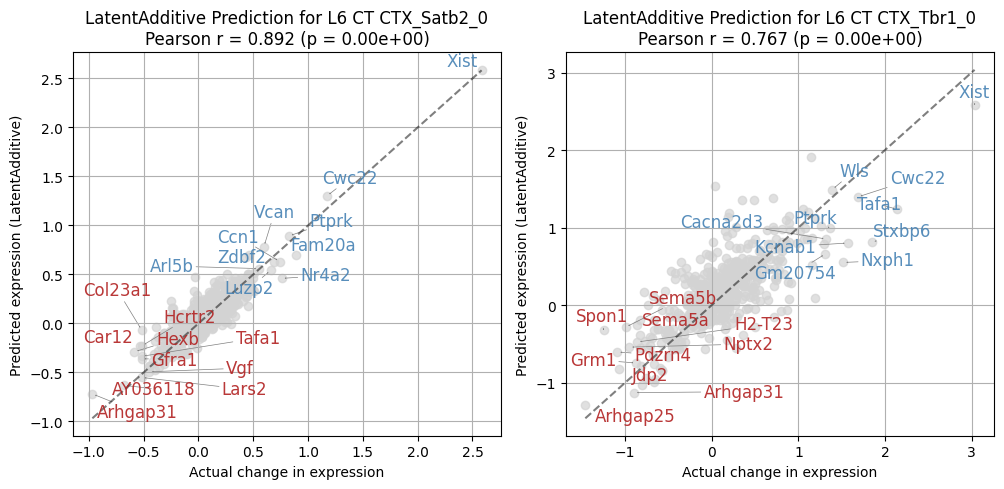

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from adjustText import adjust_text 
import pickle 
import math
import scanpy as sc

# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/raw_data/boli_ctx_scprocess_no+ctrl.h5ad')

# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-09-26_11-01-16_boli_linear_baseline/evaluation/eval.pkl"
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-07_11-33-35/3/evaluation/eval.pkl"

# # linear 2k genes
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear_hvg/linear_baseline_hvg.h5ad')
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-26_17-20-19/1/evaluation/eval.pkl"

# linear 32k genes
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear/linear_baseline.h5ad')
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-28_13-44-13/2/evaluation/eval.pkl"

# # STATE latent 32k genes
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear/linear_baseline.h5ad')
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-11-07_09-32-27_boli_linear_baseline/evaluation/eval.pkl"
# model_name = "LatentAdditive"

# STATE latent 2k HVG
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear_hvg/linear_baseline_hvg.h5ad')
pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-11-07_09-53-57_boli_linear_baseline/evaluation/eval.pkl"
model_name = "LatentAdditive"

with open(pkl_res, "rb") as f:
    eval_data = pickle.load(f)
df_pred = eval_data.aggr["logfc"][model_name].to_df()
df_ref = eval_data.aggr["logfc"]["ref"].to_df()
genes = boli.var["gene_name"].values

cell_perts = df_pred.index.tolist()
num_plots = len(cell_perts)
cols = int(math.ceil(math.sqrt(num_plots))) + 2
rows = int(math.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.flatten()
for i, cell_pert in enumerate(cell_perts):
    ax = axes[i]
    x_vals = df_ref.loc[cell_pert].values
    y_vals = df_pred.loc[cell_pert].values
    
    #cos_sim = cosine_similarity(x_vals.reshape(1, -1), y_vals.reshape(1, -1))[0, 0]
    pearson_r, p_value = pearsonr(x_vals, y_vals)

    top10_idx = np.argsort(x_vals)[-10:]
    bottom10_idx = np.argsort(x_vals)[:10]
    top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

    colors = ["steelblue" if idx in top10_idx else "firebrick" for idx in range(len(y_vals))]

    ax.scatter(x_vals, y_vals, alpha=0.7, color="lightgray")
    ax.plot([x_vals.min(), x_vals.max()], [x_vals.min(), x_vals.max()], 'k--', alpha=0.5)
    ax.set_xlabel("Actual change in expression")
    ax.set_ylabel(f"Predicted expression ({model_name})")
    #ax.set_title(f"{model_name} Prediction for {cell_pert} \nCosine similarity = {cos_sim:.3f}")
    ax.set_title(f"{model_name} Prediction for {cell_pert}\nPearson r = {pearson_r:.3f} (p = {p_value:.2e})")

    ax.grid(True)

    texts = []
    for idx in top_and_bottom_idx:
        color = "steelblue" if idx in top10_idx else "firebrick"
        texts.append(
            ax.text(
                x_vals[idx], y_vals[idx], genes[idx],
                fontsize=12,
                color=color,
                alpha=0.9,
                ha='right' if idx in top10_idx else 'left',
                va='bottom'
            )
        )
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

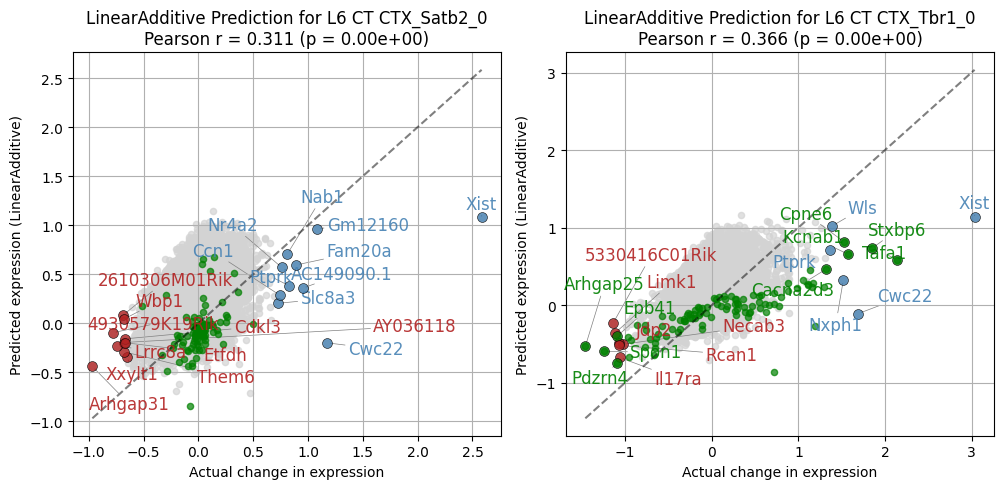

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from adjustText import adjust_text 
import pickle 
import math
import scanpy as sc
import pandas as pd

boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/raw_data/boli_ctx_scprocess_no+ctrl.h5ad')
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear/linear_baseline.h5ad')

pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-09-26_11-01-16_boli_linear_baseline/evaluation/eval.pkl"
pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-07_11-33-35/3/evaluation/eval.pkl"
pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-28_13-44-13/2/evaluation/eval.pkl"

with open(pkl_res, "rb") as f:
    eval_data = pickle.load(f)
model_name = "LinearAdditive"
df_pred = eval_data.aggr["logfc"][model_name].to_df()
df_ref = eval_data.aggr["logfc"]["ref"].to_df()
genes = boli.var["gene_name"].values

# Define your DEG list here
#deg_genes = set(["GENE1", "GENE2", "GENE3"])  # Replace with your actual DEG list
# Or load from a file:
deg_genes = set(pd.read_csv("/gpfs/home/asun/jin_lab/perturbench/raw_data/top100_ctx_tbr1_L6_CT_CTX.csv")["names"].tolist())

cell_perts = df_pred.index.tolist()
num_plots = len(cell_perts)
cols = int(math.ceil(math.sqrt(num_plots))) + 2
rows = int(math.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.flatten()

for i, cell_pert in enumerate(cell_perts):
    ax = axes[i]
    x_vals = df_ref.loc[cell_pert].values
    y_vals = df_pred.loc[cell_pert].values
    
    pearson_r, p_value = pearsonr(x_vals, y_vals)

    top10_idx = np.argsort(x_vals)[-10:]
    bottom10_idx = np.argsort(x_vals)[:10]
    top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

    # Separate DEGs from non-DEGs for plotting
    deg_mask = np.array([gene in deg_genes for gene in genes])
    non_deg_mask = ~deg_mask
    
    # Plot non-DEGs in gray
    ax.scatter(x_vals[non_deg_mask], y_vals[non_deg_mask], alpha=0.7, color="lightgray", s=20, zorder=1)
    
    # Plot DEGs in green on top
    ax.scatter(x_vals[deg_mask], y_vals[deg_mask], alpha=0.7, color="green", s=20, zorder=2)
    
    ax.plot([x_vals.min(), x_vals.max()], [x_vals.min(), x_vals.max()], 'k--', alpha=0.5)
    ax.set_xlabel("Actual change in expression")
    ax.set_ylabel(f"Predicted expression ({model_name})")
    ax.set_title(f"{model_name} Prediction for {cell_pert}\nPearson r = {pearson_r:.3f} (p = {p_value:.2e})")
    ax.grid(True)

    texts = []
    for idx in top_and_bottom_idx:
        gene_name = genes[idx]
        
        # Determine color: green for DEGs, otherwise blue/red based on direction
        if gene_name in deg_genes:
            color = "green"
        elif idx in top10_idx:
            color = "steelblue"
        else:
            color = "firebrick"
        
        # Highlight labeled points with larger size and black edge
        ax.scatter(x_vals[idx], y_vals[idx], color=color, s=50, alpha=0.8, 
                  edgecolors='black', linewidths=0.5, zorder=3)
        
        texts.append(
            ax.text(
                x_vals[idx], y_vals[idx], gene_name,
                fontsize=12,
                color=color,
                alpha=0.9,
                ha='right' if idx in top10_idx else 'left',
                va='bottom'
            )
        )
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Total genes: 2000, DEG genes: 28


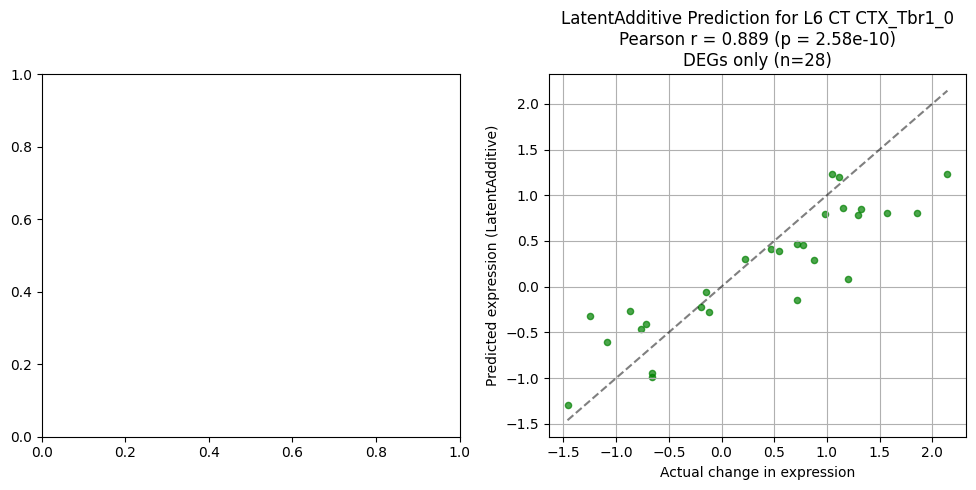

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from adjustText import adjust_text 
import pickle 
import math
import scanpy as sc

# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/raw_data/boli_ctx_scprocess_no+ctrl.h5ad')
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear/linear_baseline.h5ad')

# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-09-26_11-01-16_boli_linear_baseline/evaluation/eval.pkl"
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-07_11-33-35/3/evaluation/eval.pkl"
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-28_13-44-13/2/evaluation/eval.pkl"

# # linear 2k genes
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear_hvg/linear_baseline_hvg.h5ad')
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-26_17-20-19/1/evaluation/eval.pkl"

# # STATE latent 32k genes
# boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear/linear_baseline.h5ad')
# pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-11-07_09-32-27_boli_linear_baseline/evaluation/eval.pkl"
# model_name = "LatentAdditive"

# STATE latent 2k HVG
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/linear_hvg/linear_baseline_hvg.h5ad')
pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-11-07_09-53-57_boli_linear_baseline/evaluation/eval.pkl"
model_name = "LatentAdditive"

with open(pkl_res, "rb") as f:
    eval_data = pickle.load(f)
df_pred = eval_data.aggr["logfc"][model_name].to_df()
df_ref = eval_data.aggr["logfc"]["ref"].to_df()
genes = boli.var["gene_name"].values

# Define your DEG list here
#deg_genes = set(["GENE1", "GENE2", "GENE3"])  # Replace with your actual DEG list
# Or load from a file:
deg_genes = set(pd.read_csv("/gpfs/home/asun/jin_lab/perturbench/raw_data/top100_ctx_tbr1_L6_CT_CTX.csv")["names"].tolist())

# Create mask for DEG genes
deg_mask = np.array([gene in deg_genes for gene in genes])
deg_indices = np.where(deg_mask)[0]

# Subset dataframes to only DEG genes
df_pred_deg = df_pred.iloc[:, deg_indices]
df_ref_deg = df_ref.iloc[:, deg_indices]
genes_deg = genes[deg_mask]

print(f"Total genes: {len(genes)}, DEG genes: {len(genes_deg)}")

cell_perts = df_pred_deg.index.tolist()
num_plots = len(cell_perts)
cols = int(math.ceil(math.sqrt(num_plots))) + 2
rows = int(math.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.flatten()

for i, cell_pert in enumerate(cell_perts):
    if i == 1:
        ax = axes[i]
        x_vals = df_ref_deg.loc[cell_pert].values
        y_vals = df_pred_deg.loc[cell_pert].values

        pearson_r, p_value = pearsonr(x_vals, y_vals)

        top10_idx = np.argsort(x_vals)[-10:]
        bottom10_idx = np.argsort(x_vals)[:10]
        top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

        # Plot all DEG genes in green
        ax.scatter(x_vals, y_vals, alpha=0.7, color="green", s=20)

        ax.plot([x_vals.min(), x_vals.max()], [x_vals.min(), x_vals.max()], 'k--', alpha=0.5)
        ax.set_xlabel("Actual change in expression")
        ax.set_ylabel(f"Predicted expression ({model_name})")
        ax.set_title(f"{model_name} Prediction for {cell_pert}\nPearson r = {pearson_r:.3f} (p = {p_value:.2e})\nDEGs only (n={len(genes_deg)})")
        ax.grid(True)

    # texts = []
    # for idx in top_and_bottom_idx:
    #     gene_name = genes_deg[idx]
        
    #     # Color based on direction
    #     if idx in top10_idx:
    #         color = "steelblue"
    #     else:
    #         color = "firebrick"
        
    #     # Highlight labeled points
    #     ax.scatter(x_vals[idx], y_vals[idx], color=color, s=50, alpha=0.8, 
    #               edgecolors='black', linewidths=0.5, zorder=3)
        
    #     texts.append(
    #         ax.text(
    #             x_vals[idx], y_vals[idx], gene_name,
    #             fontsize=12,
    #             color=color,
    #             alpha=0.9,
    #             ha='right' if idx in top10_idx else 'left',
    #             va='bottom'
    #         )
    #     )
    
    # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

In [10]:
df_pred

,4,5,7,11,14,18,19,27,41,42,...,32197,32198,32199,32200,32201,32203,32204,32205,32207,32261
L6_CT_CTX_SATB2,0.668919,0.930674,0.957817,-0.124037,0.977103,0.552633,0.863202,-0.332235,-0.236849,-0.005510,...,0.109395,0.104157,0.716670,-0.015371,0.315373,0.319431,0.843818,0.520641,0.285698,0.385907
L6_CT_CTX_TBR1,0.691533,0.905290,0.906547,-0.186878,1.040245,0.715475,0.926838,-0.256491,-0.367084,0.183742,...,0.206637,0.012361,0.685244,-0.040403,0.292648,0.323774,0.690328,0.485907,0.313843,0.419991


In [8]:
cell_perts

['L6_CT_CTX_SATB2', 'L6_CT_CTX_TBR1']

In [5]:
eval_data.aggr["logfc"]["ref"]

View of AnnData object with n_obs × n_vars = 6 × 6642
    obs: 'cell_line', 'gene', 'cov_merged'

In [11]:
genes

Index(['4', '5', '7', '11', '14', '18', '19', '27', '41', '42',
       ...
       '32197', '32198', '32199', '32200', '32201', '32203', '32204', '32205',
       '32207', '32261'],
      dtype='object', length=5000)

In [1]:
import scanpy as sc

In [2]:
test = sc.read_h5ad("/gpfs/home/asun/jin_lab/perturbench/1_train/logs/predict/runs/2025-10-26_17-35-45_boli_linear_baseline/predictions/prediction_chunk_0.h5ad")

In [5]:
test

AnnData object with n_obs × n_vars = 330 × 2000
    obs: 'predicted.subclass', 'Assign'

In [4]:
import sys, os, scipy, importlib, pkgutil
print("Python:", sys.version)
print("SciPy:", scipy.__version__, scipy.__file__)

# Show where scipy.sparse is coming from and whether linalg exists
import scipy.sparse as spmod
print("scipy.sparse path:", getattr(spmod, "__file__", "<namespace>"))
print("has linalg attribute:", hasattr(spmod, "linalg"))
try:
    import scipy.sparse.linalg as splinalg
    print("cg present:", hasattr(splinalg, "cg"))
except Exception as e:
    print("Import error for scipy.sparse.linalg:", repr(e))

Python: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
SciPy: 1.12.0 /gpfs/home/asun/miniforge3/envs/perturbbench/lib/python3.11/site-packages/scipy/__init__.py
scipy.sparse path: /gpfs/home/asun/miniforge3/envs/perturbbench/lib/python3.11/site-packages/scipy/sparse/__init__.py
has linalg attribute: False
cg present: True


In [2]:
import scanpy as sc
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/boli_ctx_scprocess_no+ctrl.h5ad')


AttributeError: module 'scipy.sparse' has no attribute 'linalg'

In [14]:
boli

AnnData object with n_obs × n_vars = 21700 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'Assign', 'scds', 'cxds', 'bcds', 'Sample', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score', 'predicted.subclass', 'CT', 'mito', 'BioSamp', 'CT2', 'ForPlot', 'Remove', 'active_ident', 'Assign_clean', 'condition', 'cell_type', 'cell_class'
    var: 'variable_gene', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [15]:
boli.var["gene_name"].values

array(['Rp1', 'Sox17', 'Gm37323', ..., 'mt-Nd5', 'mt-Cytb',
       'CAAA01147332.1'], dtype=object)

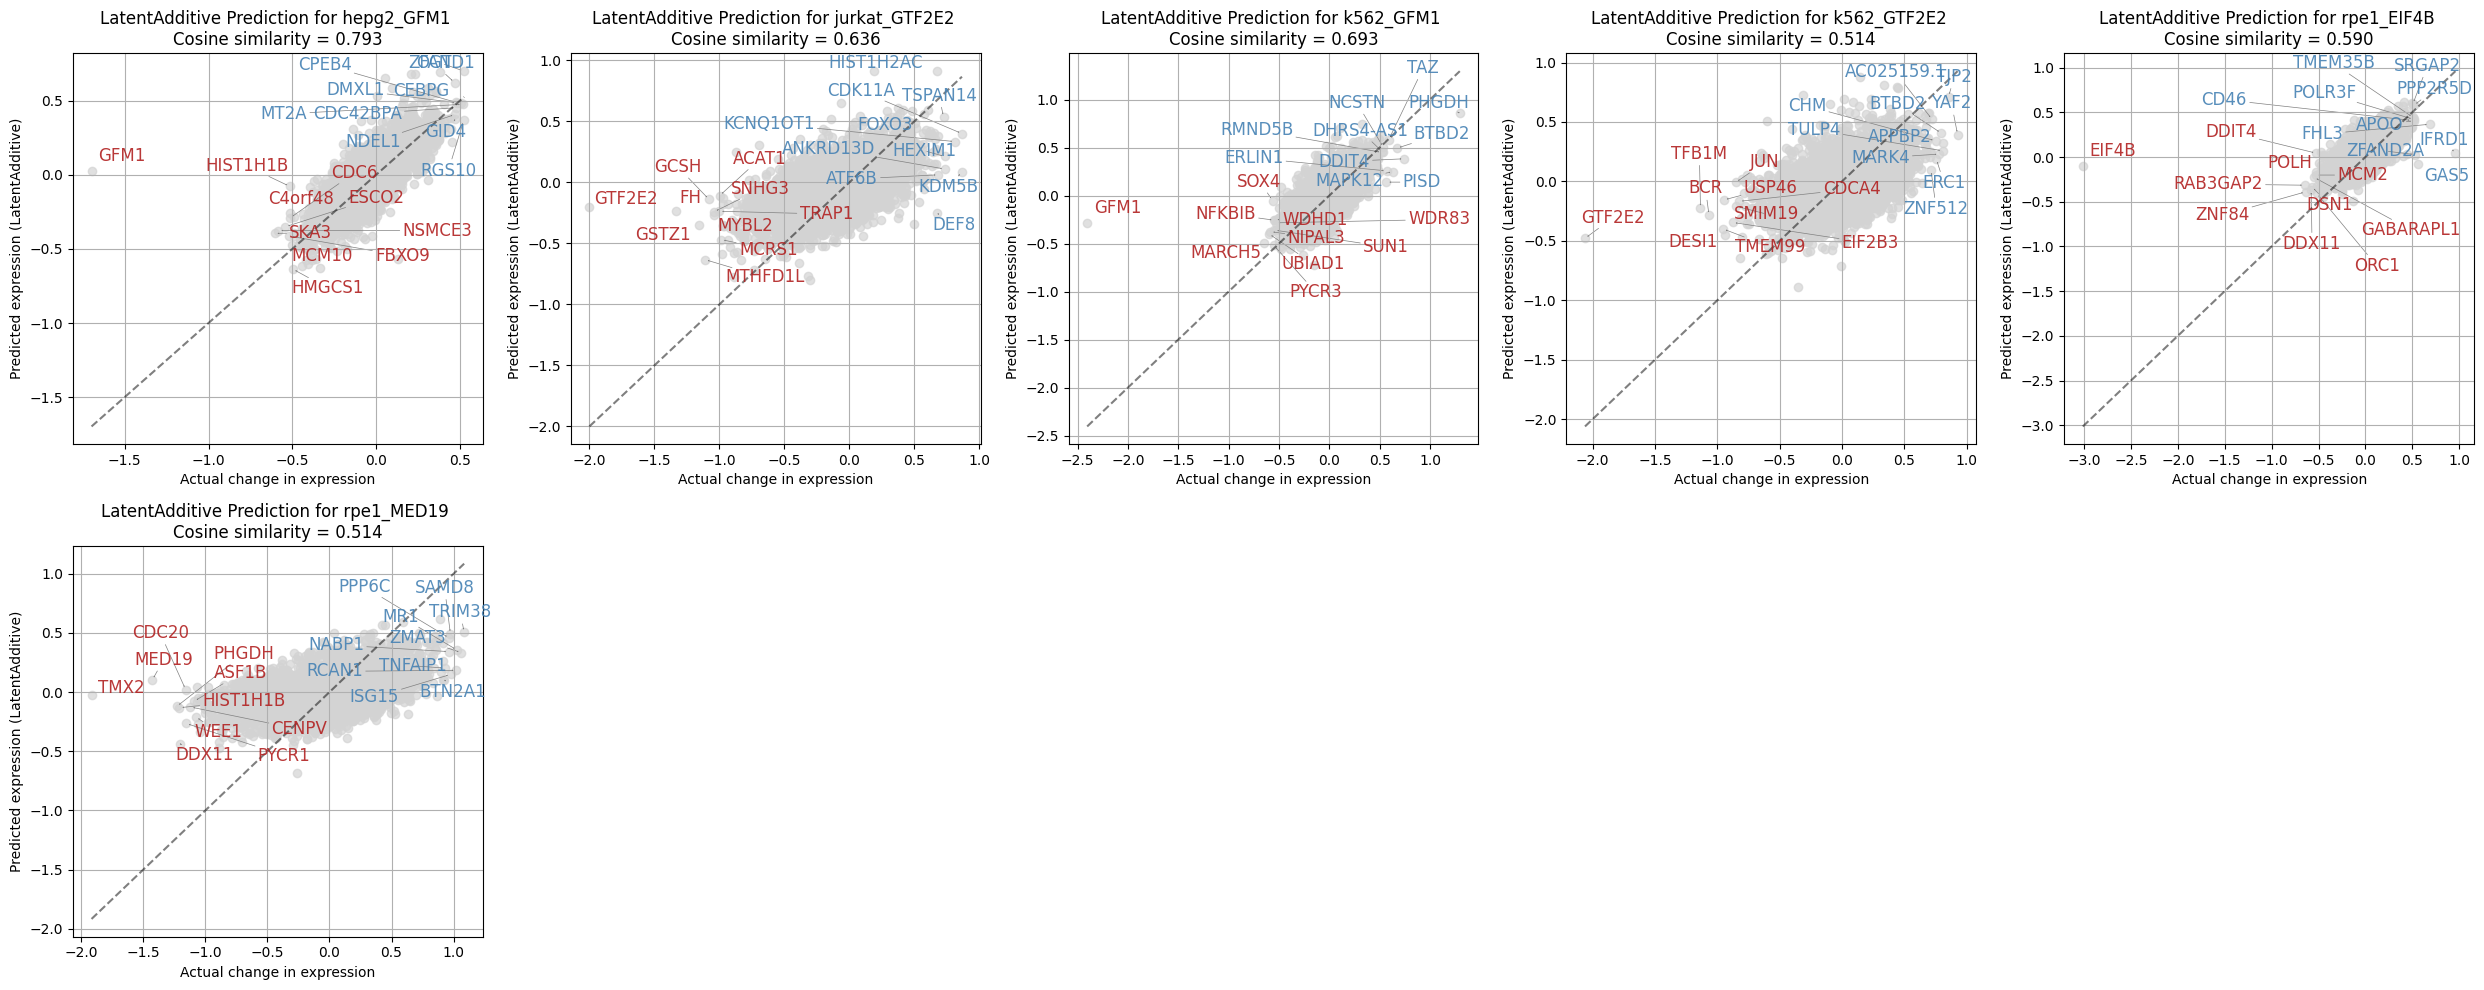

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from adjustText import adjust_text 
import pickle 
import math

pkl_res = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/0_replogle_qual_high_amt_high/evaluation/eval.pkl"
with open(pkl_res, "rb") as f:
    eval_data = pickle.load(f)
model_name = "LatentAdditive"
df_pred = eval_data.aggr["logfc"][model_name].to_df()
df_ref = eval_data.aggr["logfc"]["ref"].to_df()
genes = df_pred.columns


cell_perts = df_pred.index.tolist()
num_plots = len(cell_perts)
cols = int(math.ceil(math.sqrt(num_plots))) + 2
rows = int(math.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.flatten()
for i, cell_pert in enumerate(cell_perts):
    ax = axes[i]
    x_vals = df_ref.loc[cell_pert].values
    y_vals = df_pred.loc[cell_pert].values
    cos_sim = cosine_similarity(x_vals.reshape(1, -1), y_vals.reshape(1, -1))[0, 0]

    top10_idx = np.argsort(x_vals)[-10:]
    bottom10_idx = np.argsort(x_vals)[:10]
    top_and_bottom_idx = set(top10_idx).union(set(bottom10_idx))

    colors = ["steelblue" if idx in top10_idx else "firebrick" for idx in range(len(y_vals))]

    ax.scatter(x_vals, y_vals, alpha=0.7, color="lightgray")
    ax.plot([x_vals.min(), x_vals.max()], [x_vals.min(), x_vals.max()], 'k--', alpha=0.5)
    ax.set_xlabel("Actual change in expression")
    ax.set_ylabel(f"Predicted expression ({model_name})")
    ax.set_title(f"{model_name} Prediction for {cell_pert} \nCosine similarity = {cos_sim:.3f}")
    ax.grid(True)

    texts = []
    for idx in top_and_bottom_idx:
        color = "steelblue" if idx in top10_idx else "firebrick"
        texts.append(
            ax.text(
                x_vals[idx], y_vals[idx], genes[idx],
                fontsize=12,
                color=color,
                alpha=0.9,
                ha='right' if idx in top10_idx else 'left',
                va='bottom'
            )
        )
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), ax=ax)

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()